In [124]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def load_data(filename):
    """function to load data"""
    x = scipy.io.loadmat(filename)['PDmean'][30:90,:]*100
    return x

global T4_Arclight, T4_Gcamp #global varaiables to hold Arclight and Gcamp data

filename = 'data/T4c_ArcLight/ARCOri_Velocity_Mean.mat' 
T4_Arclight = load_data(filename)  #load Arclight data

filename = 'data/T4c_GCaMP/Ori_Mean_Velocity.mat'
T4_Gcamp = load_data(filename)  #load Gcamp data

global p_bounds #bounds on parameters (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift)
p_bounds = ((-100,100),(0,200),(0,200),(0,200),(0,200),(0,200),(-100,100))

def plot_data(data_list, dt=0.0769, fig_size=(10,10), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    #x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                #ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def plot_data_twinaxis(data_list, dt=0.0769, fig_size=(10,10), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                if c_count == 0:
                    ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                else :
                    ax1 = ax[i,j].twinx()
                    ax1.plot(x_values, data[:, count], color=c[c_count])
                    ax1.set_ylim(-20,250)
                #ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        

        
#plot_data([T4_Arclight]) 

def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy 

def Ca_model(x, p, dt=0.0769):
    """x is Arclight data. p is list of parameters. dt is timestep"""
    (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift) = p
    x_thres = threshold_cut(x,thres/100.0)
    x_thres_bp1 = bandpass(x_thres, tauhp/20, taulp1/20, dt)
    x_1 = x_thres_bp1 * gain1
    x_thres_bp2 = bandpass(x_thres, tauhp/20, taulp2/20, dt)
    x_2 = x_thres_bp2 * gain2
    y = x_1 + x_2
    y = np.roll(y, int(tshift), axis=0)
    return y

def create_random_params():
    p = [np.random.uniform(bounds[0], bounds[1]) for bounds in p_bounds]
    #print(p)
    return p  

def calc_error(p):
    T4Ca_model = Ca_model(T4_Arclight, p)
    #error1 = np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2)) #timeerror
    error1 = np.mean(np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2,axis=0)))
    error2 = np.sqrt(np.mean((T4_Gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2)) #peakerror
    timeerror = 0.9 #weight for time error
    error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
    return error

def fit_params():
    p = create_random_params() #creates random parameter values
    #options = {'maxiter':5000} #maximum number of iterations
    res = minimize(calc_error, p, tol=1e-10, bounds=p_bounds)#options=options
    if res.success:
        print('Optimisation successful')
    else:
        print('Optimisation not succesfull')
    p = res.x
    error = calc_error(p)
    print('Remaining Error: ', format(calc_error(p),".2f"))
    print(res)
    return p, error

In [125]:
def many_runs(n):
    (p_list, err_list) = ([],[]) 
    for i in range(n):
        print('run : '+str(i))
        (par, err) = fit_params()
        print(par)
        p_list.append(par)
        err_list.append(err)
    return p_list, err_list
    

In [126]:
para_list, err_list = many_runs(20)

run : 0
Optimisation successful
('Remaining Error: ', '22.75')
      fun: 22.747771833210518
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 3.55271368e-07, 0.00000000e+00, 4.36983782e-05,
       0.00000000e+00, 3.55271368e-07, 0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 472
      nit: 36
   status: 0
  success: True
        x: array([ 96.43696309,  44.15952317, 197.92349268,   0.        ,
        44.13982493,  19.81678461,  71.31755009])
[ 96.43696309  44.15952317 197.92349268   0.          44.13982493
  19.81678461  71.31755009]
run : 1
Optimisation successful
('Remaining Error: ', '22.01')
      fun: 22.01273791450375
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -3.55271368e-07,  1.06581410e-06, -3.19744231e-06,
        0.00000000e+00,  2.13162821e-06,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 440
      n

Optimisation successful
('Remaining Error: ', '22.20')
      fun: 22.20081399264133
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -1.88293825e-05, -3.55271368e-07,  3.55271368e-07,
       -1.91846539e-05,  0.00000000e+00,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 744
      nit: 58
   status: 0
  success: True
        x: array([ 85.22961057, 200.        ,   3.46812695,   7.03786211,
       200.        ,   6.32416214,  91.40073302])
[ 85.22961057 200.           3.46812695   7.03786211 200.
   6.32416214  91.40073302]
run : 15
Optimisation successful
('Remaining Error: ', '22.66')
      fun: 22.657753048443574
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  2.13162821e-06,  0.00000000e+00,  1.50674140e-02,
       -7.10542736e-07, -4.97379915e-06,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 17
 

In [127]:
model_para = para_list[np.argmin(err_list)]
print(np.min(err_list))
print(model_para)

21.19879353720085
[ 64.28724519 200.           6.46797205   9.66986889 200.
  16.52171764  57.22120072]


In [128]:
#model_p = fit_params()
T4Ca_model = Ca_model(T4_Arclight, model_para)
#plot_data([T4_Gcamp, T4Ca_model])

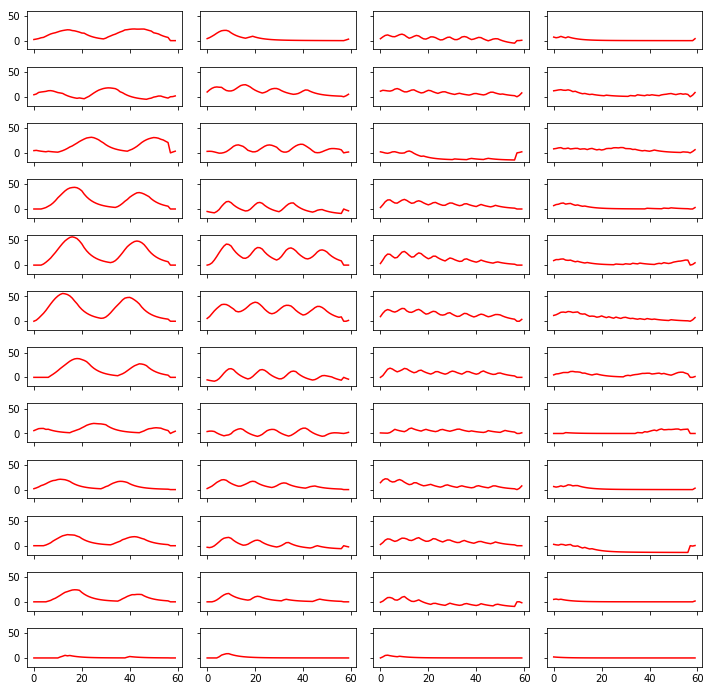

In [129]:
plot_data([T4Ca_model],c=['r'])

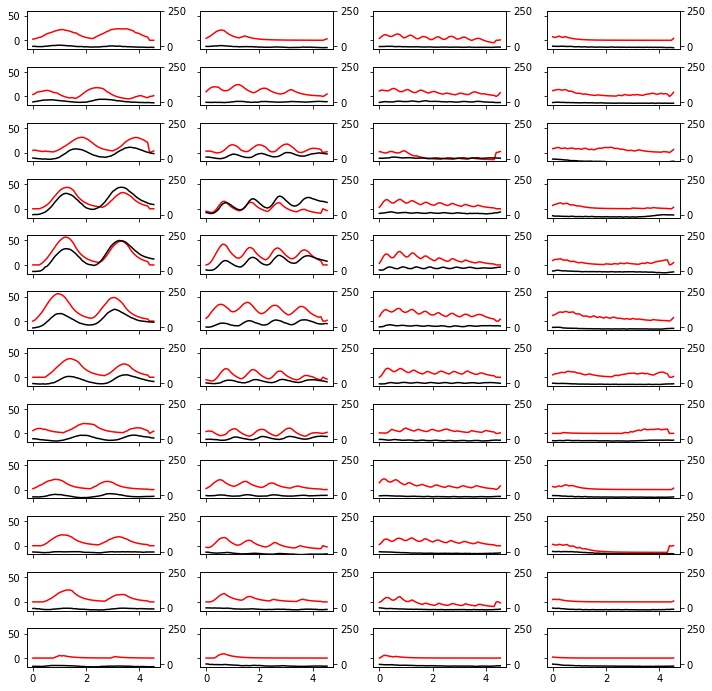

In [130]:
plot_data_twinaxis([T4Ca_model, T4_Gcamp], c=['r','k'])

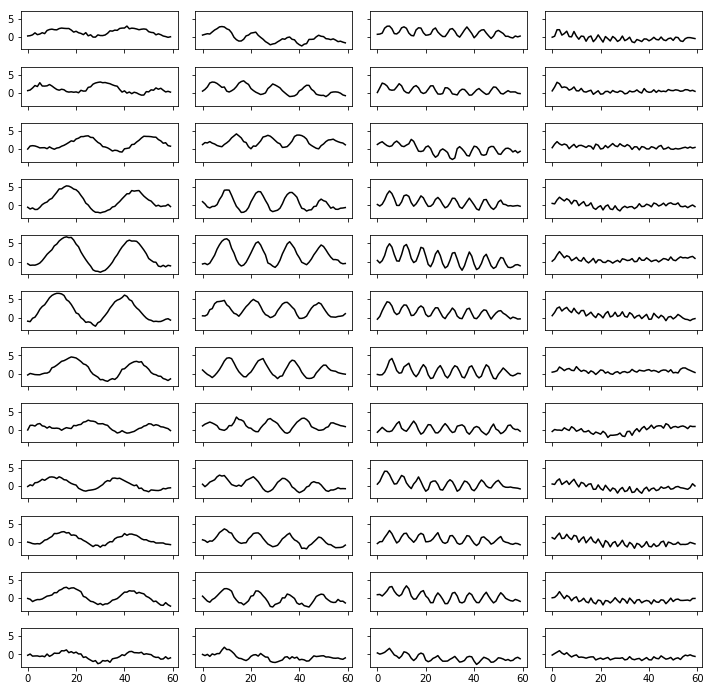

In [131]:
plot_data([T4_Arclight])

In [71]:
err_list

[180.34640120317502,
 182.25376602107934,
 184.2247085539273,
 182.7827911480615,
 181.73349749567657,
 177.88518283969404,
 177.7934342971376,
 173.58077076743035,
 180.57128963152172,
 172.41405028694422]

In [73]:
np.argmin(err_list)

9

In [62]:
i = 2
print('run'+str(i))

run2


[-96.52278540147468, 2.7447402688468125, 171.21246205746837, 69.88177546647243, 141.1222497826284, 96.21993675420009, -24.40669855004876]
Optimisation successful
('Remaining Error: ', '182.22')
      fun: 182.21788949373155
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -2.84217094e-06, -7.02016223e-04, -8.10018719e-04,
       -7.02016223e-04, -8.10018719e-04,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 328
      nit: 35
   status: 0
  success: True
        x: array([-96.5227854 ,   1.94393773, 200.        , 200.        ,
       200.        , 200.        , -24.40669855])


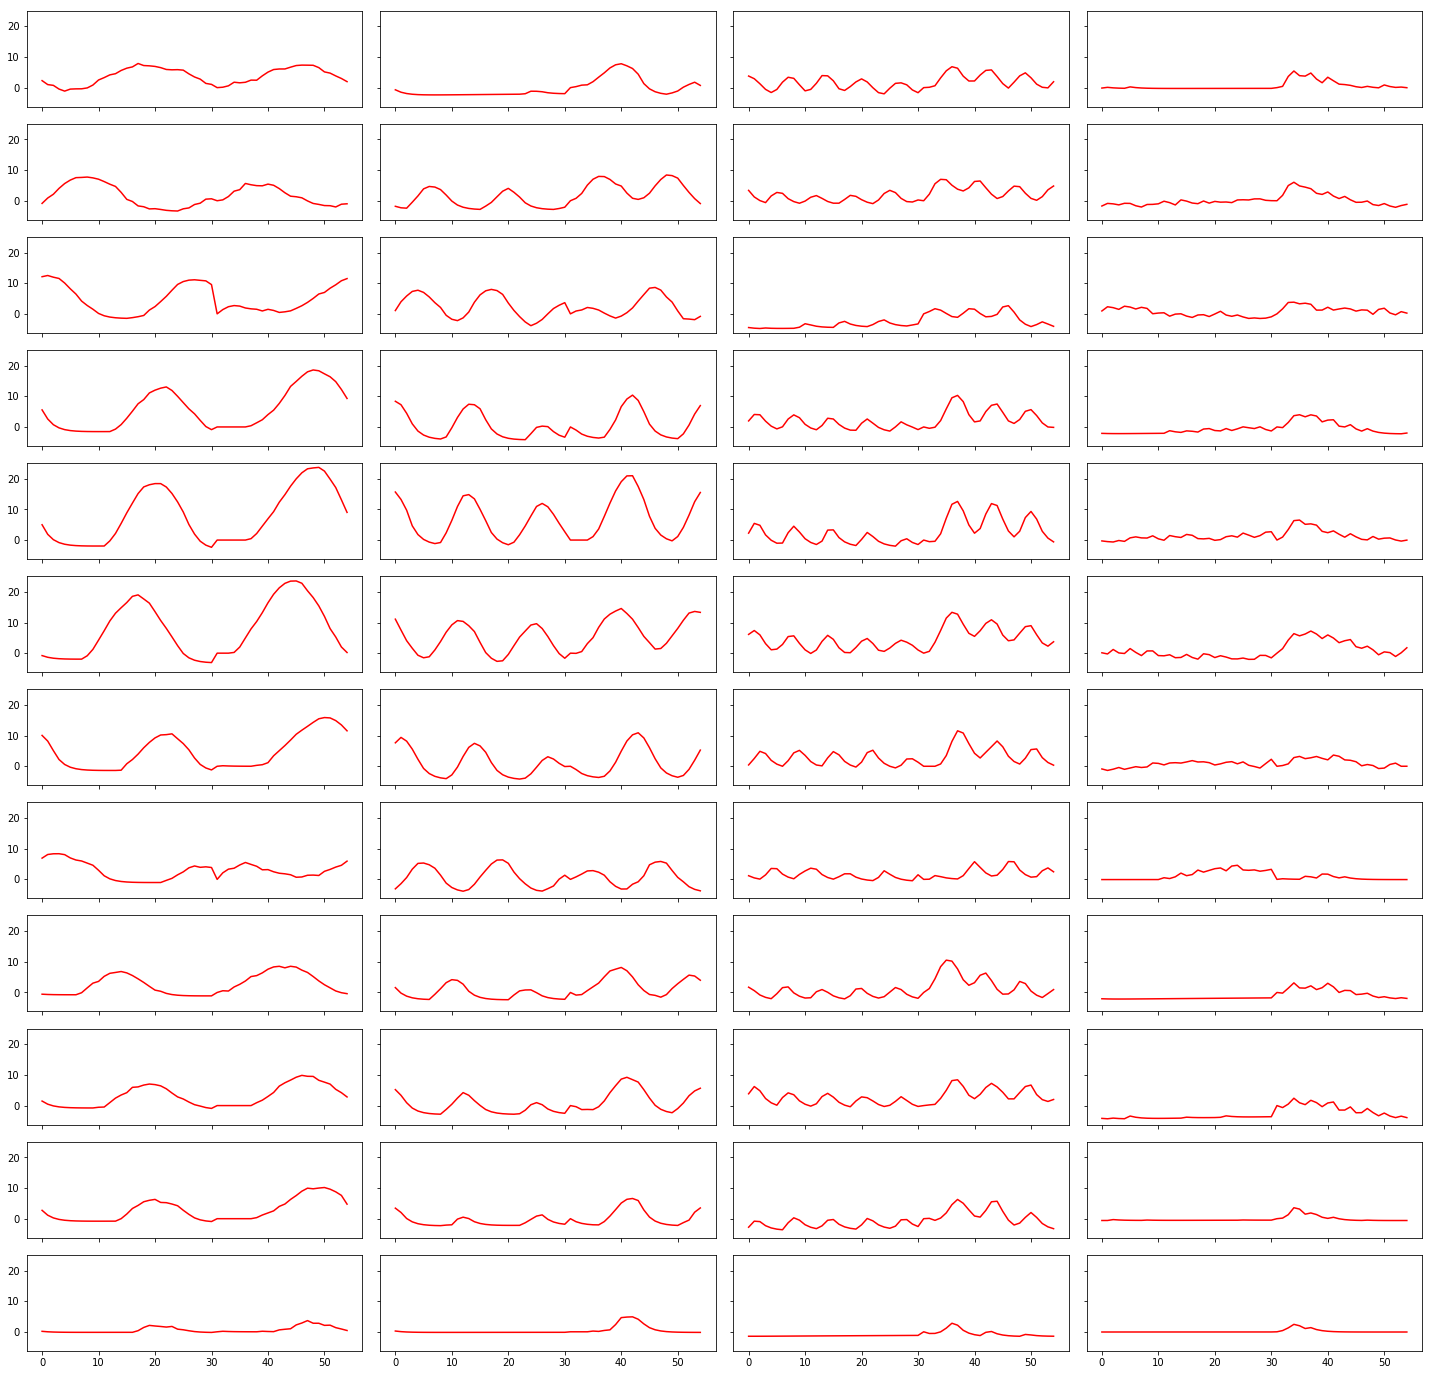

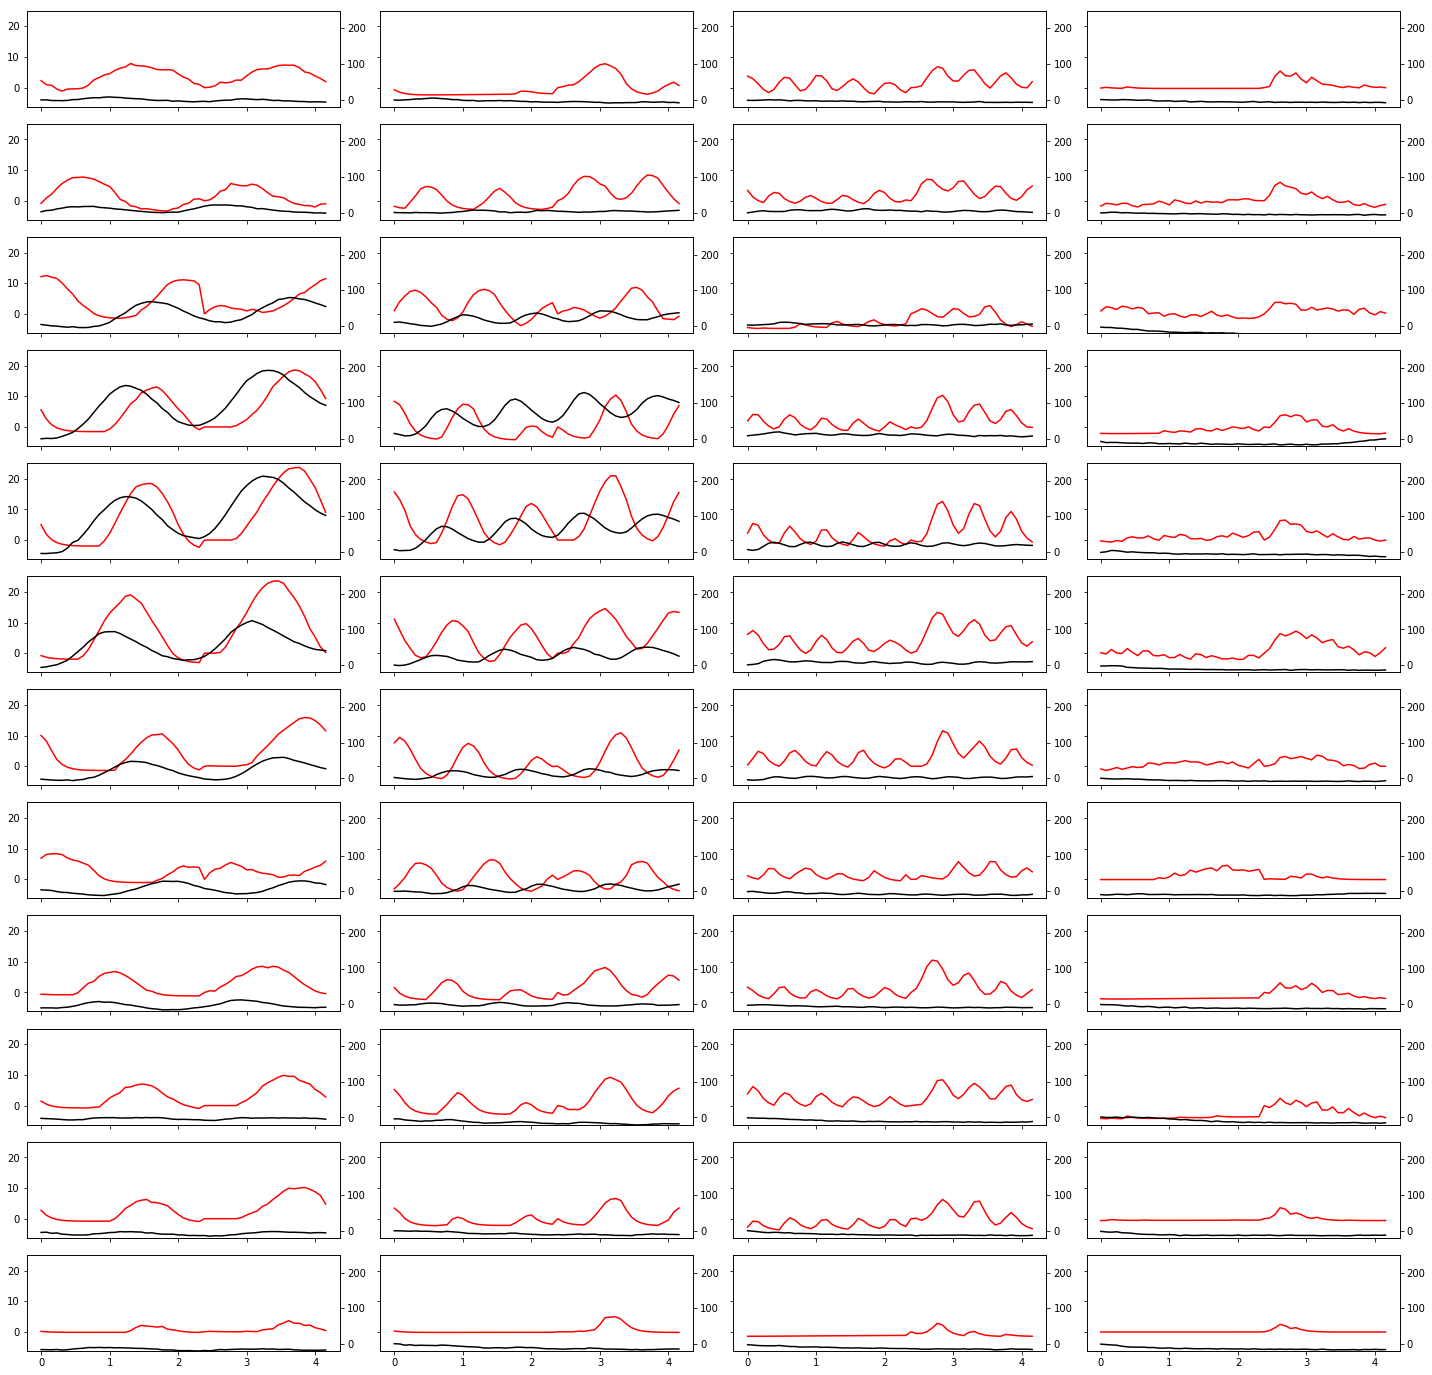

In [58]:
plot_data_twinaxis([T4Ca_model, T4_Gcamp], c=['r','k'])

In [9]:
def plot_data_twinaxis(data_list, dt=0.0769, fig_size=(20,20), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                if c_count == 0:
                    ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                else :
                    ax1 = ax[i,j].twinx()
                    ax1.plot(x_values, data[:, count], color=c[c_count])
                    ax1.set_ylim(-20,250)
#                     if c_count >= 1 & count >=1:
#                         ax1.get_shared_y_axes().join(ax1, ax2)
#                     ax2 = ax1
                #ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    #ax[0,0].get_shared_y_axes().join(ax[0,0],ax[1,0])
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);

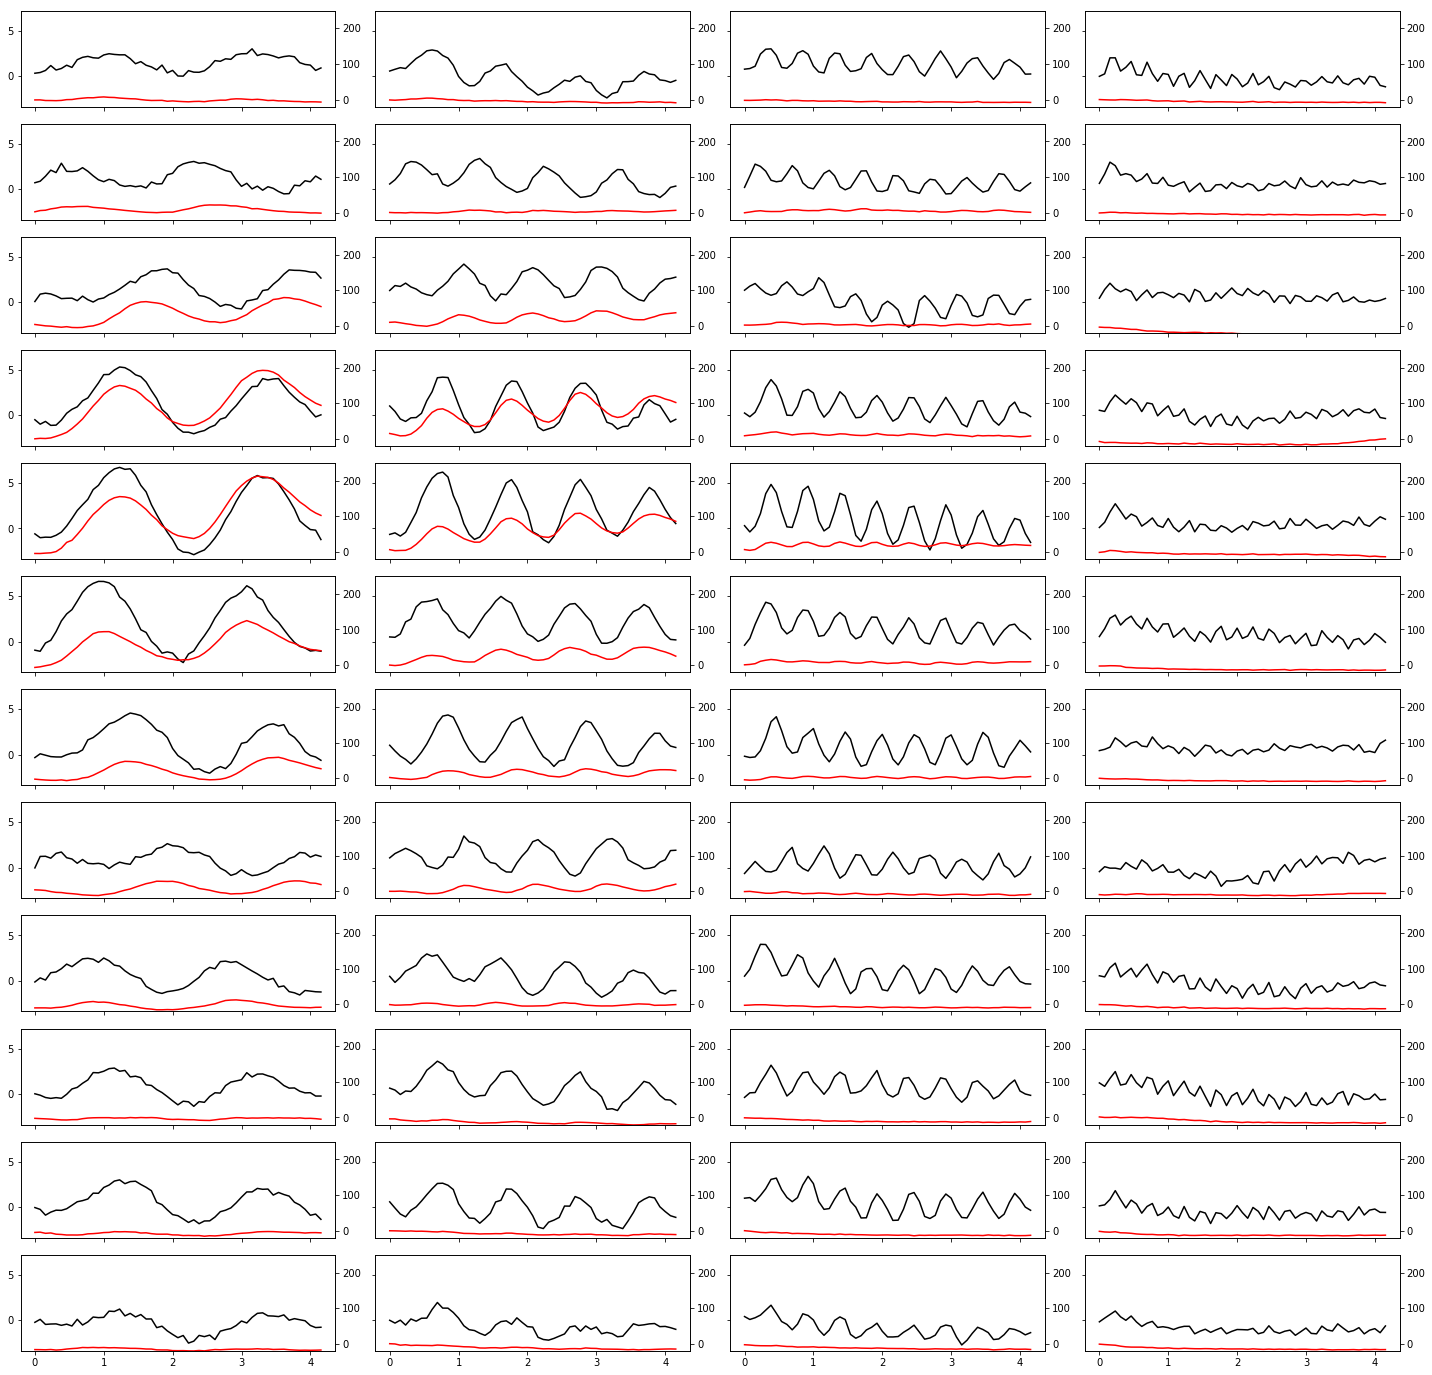

In [10]:
plot_data_twinaxis([T4_Arclight, T4_Gcamp])

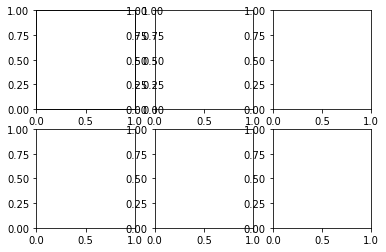

In [40]:
f

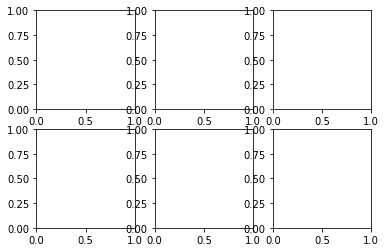

In [46]:
f, ax = plt.subplots(2,3)

In [47]:
ax1 = ax.secondary_yaxis('right')

AttributeError: 'numpy.ndarray' object has no attribute 'secondary_yaxis'

In [59]:
np.mean(np.sqrt(np.mean(((T4_Gcamp-T4_model)*10)**2,axis=0)))

2.011232973862974

In [35]:
np.mean(((T4_Gcamp - T4_model)**2), axis=0)

array([0.00224639, 0.003213  , 0.00247303, 0.0032542 , 0.00706942,
       0.00120909, 0.00215062, 0.0017651 , 0.12091762, 0.03988891,
       0.00157482, 0.03015316, 0.68493627, 0.40707545, 0.01280178,
       0.01030277, 0.83778071, 0.29391166, 0.0312674 , 0.00321207,
       0.23255166, 0.05244312, 0.00384254, 0.01061392, 0.04862553,
       0.01364012, 0.00510897, 0.00353305, 0.01393347, 0.01041812,
       0.00466972, 0.00558145, 0.00689314, 0.00112138, 0.00376597,
       0.00648826, 0.00147665, 0.0191608 , 0.00756343, 0.01006042,
       0.0060369 , 0.00644942, 0.00844628, 0.00953333, 0.01980162,
       0.0106963 , 0.01075586, 0.01291187])

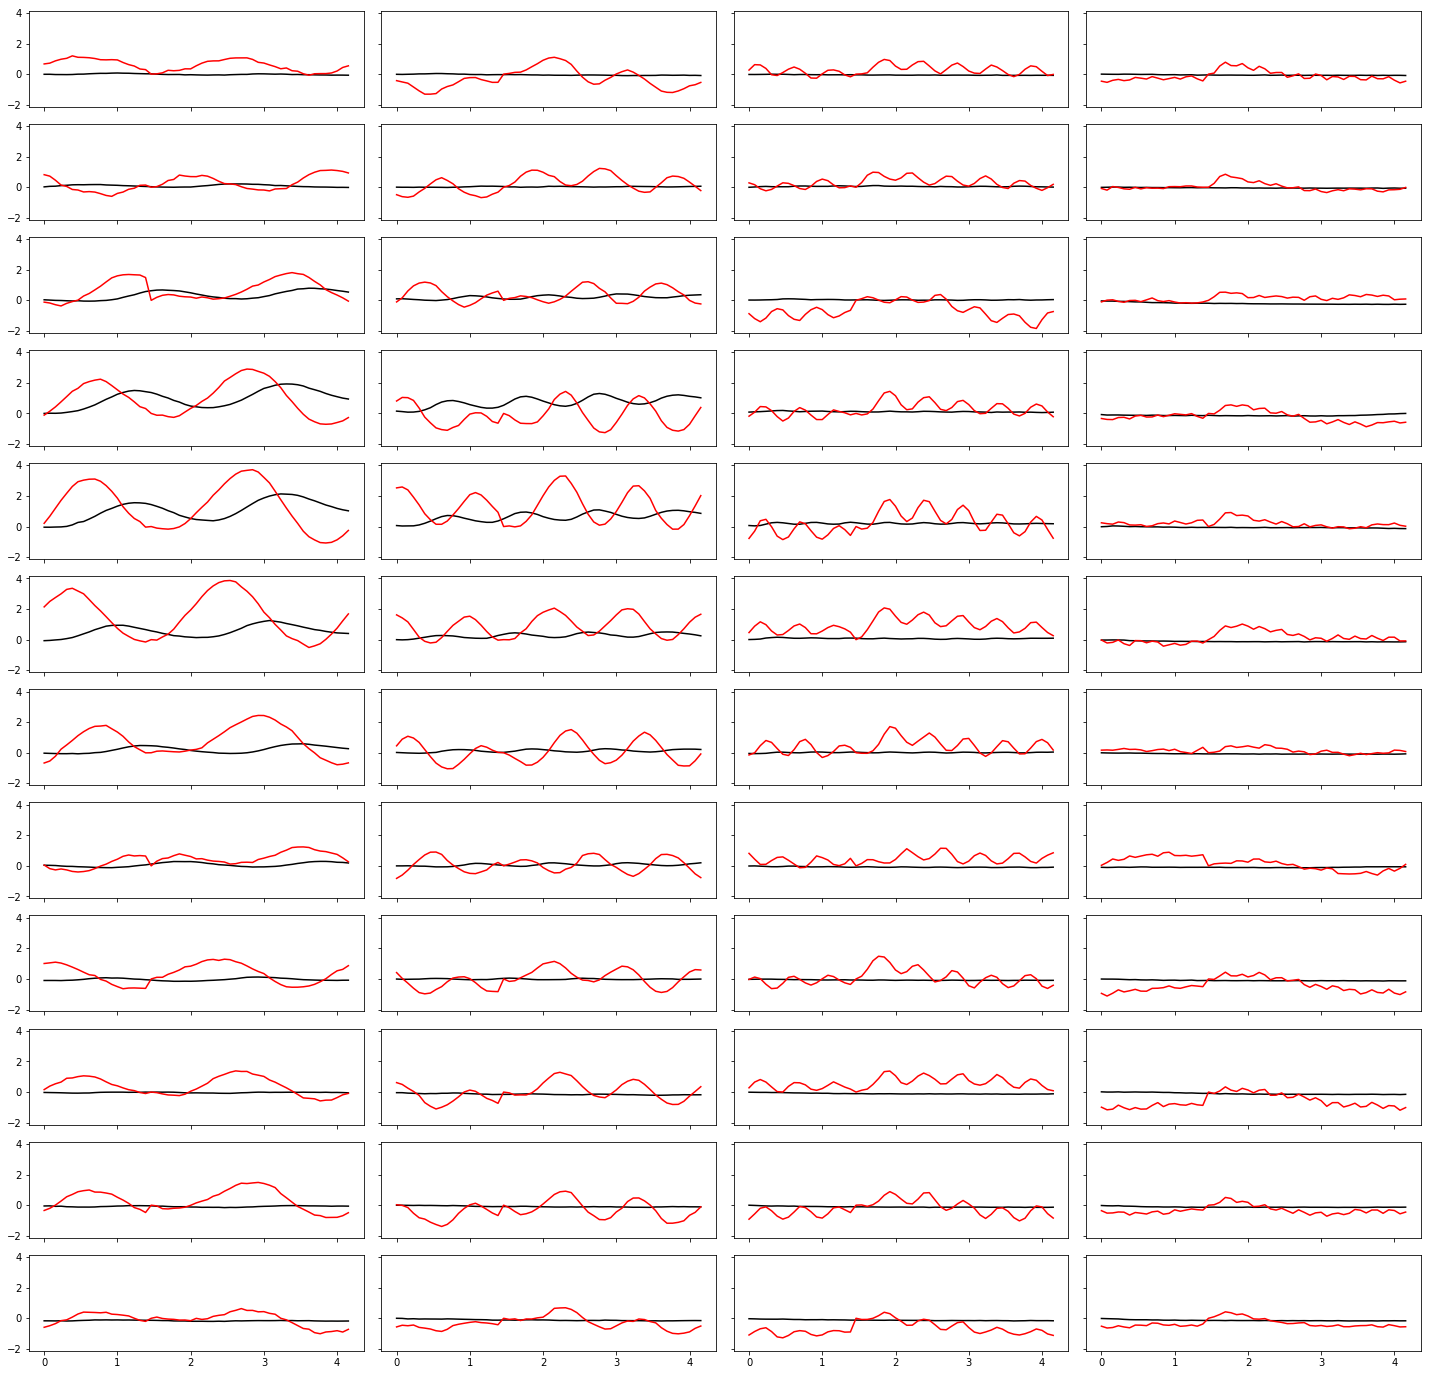

In [63]:
plot_data([T4_Gcamp,T4_model])

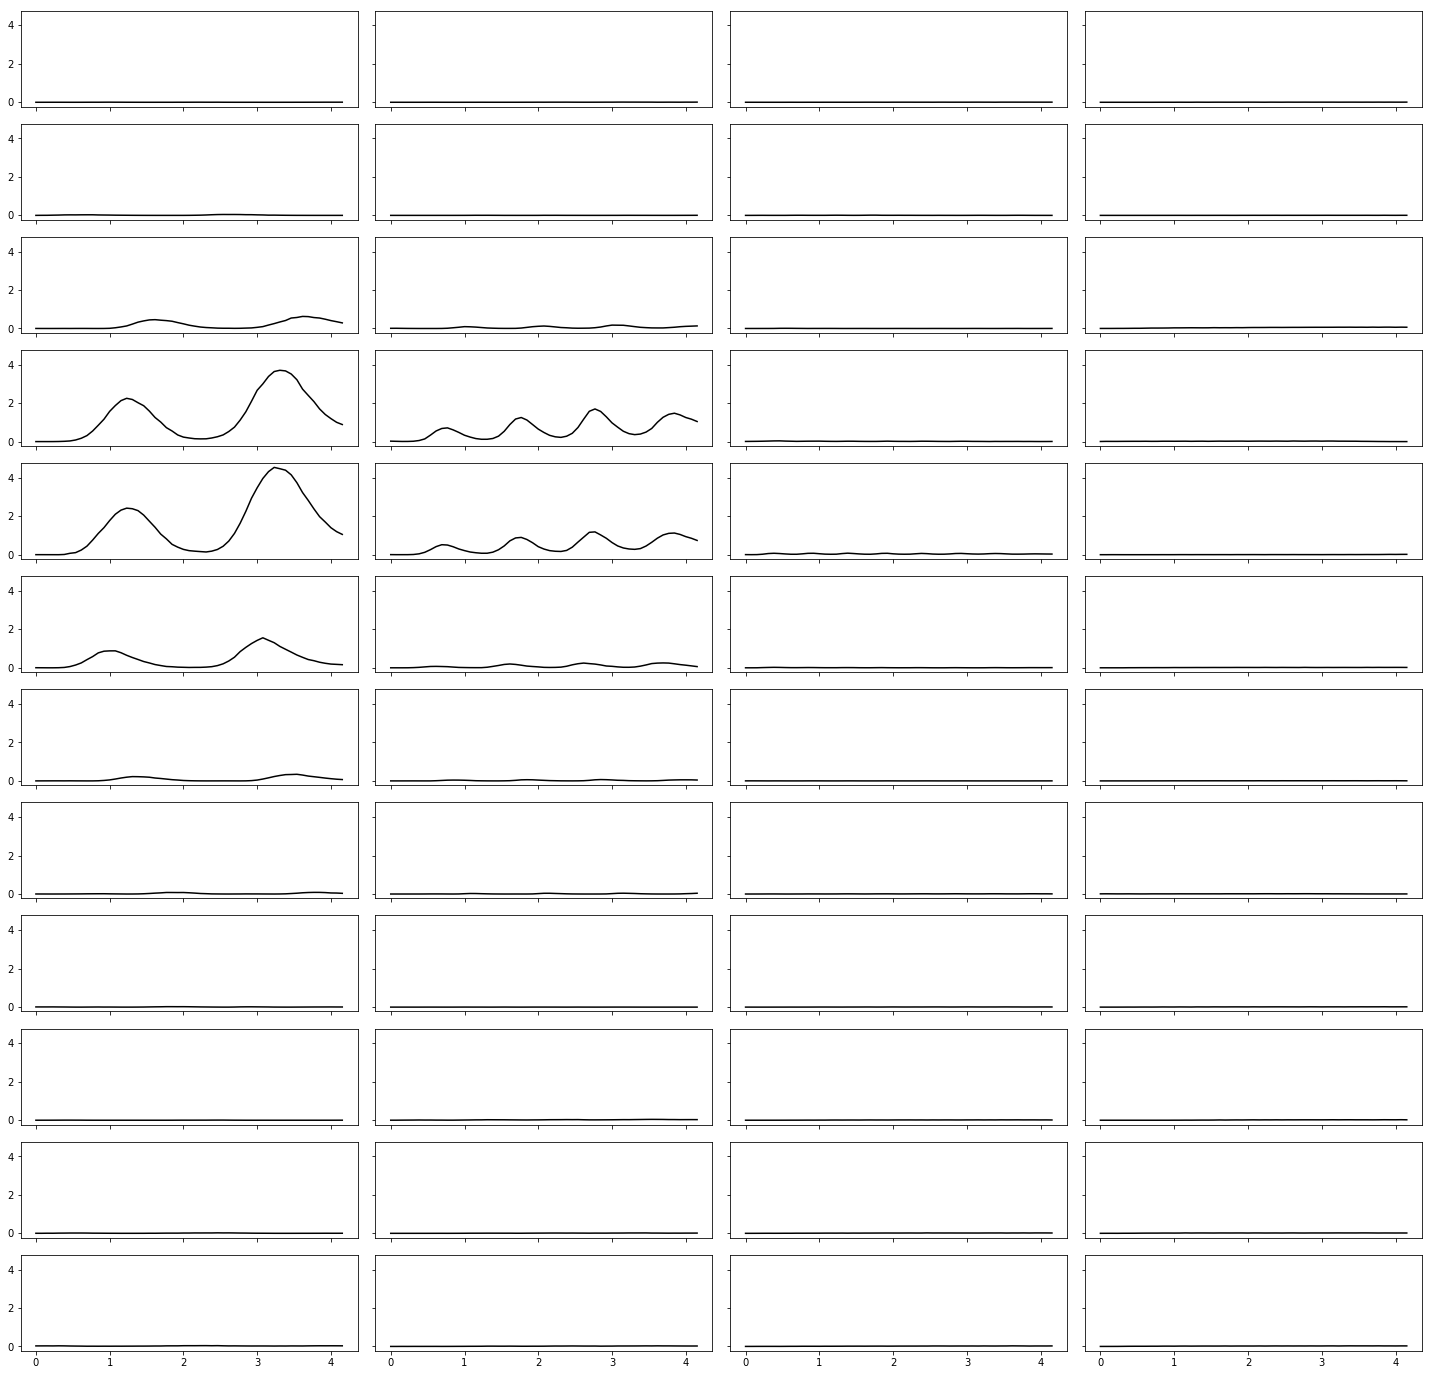

In [47]:
plot_data([(T4_Gcamp-T4_model)**2])

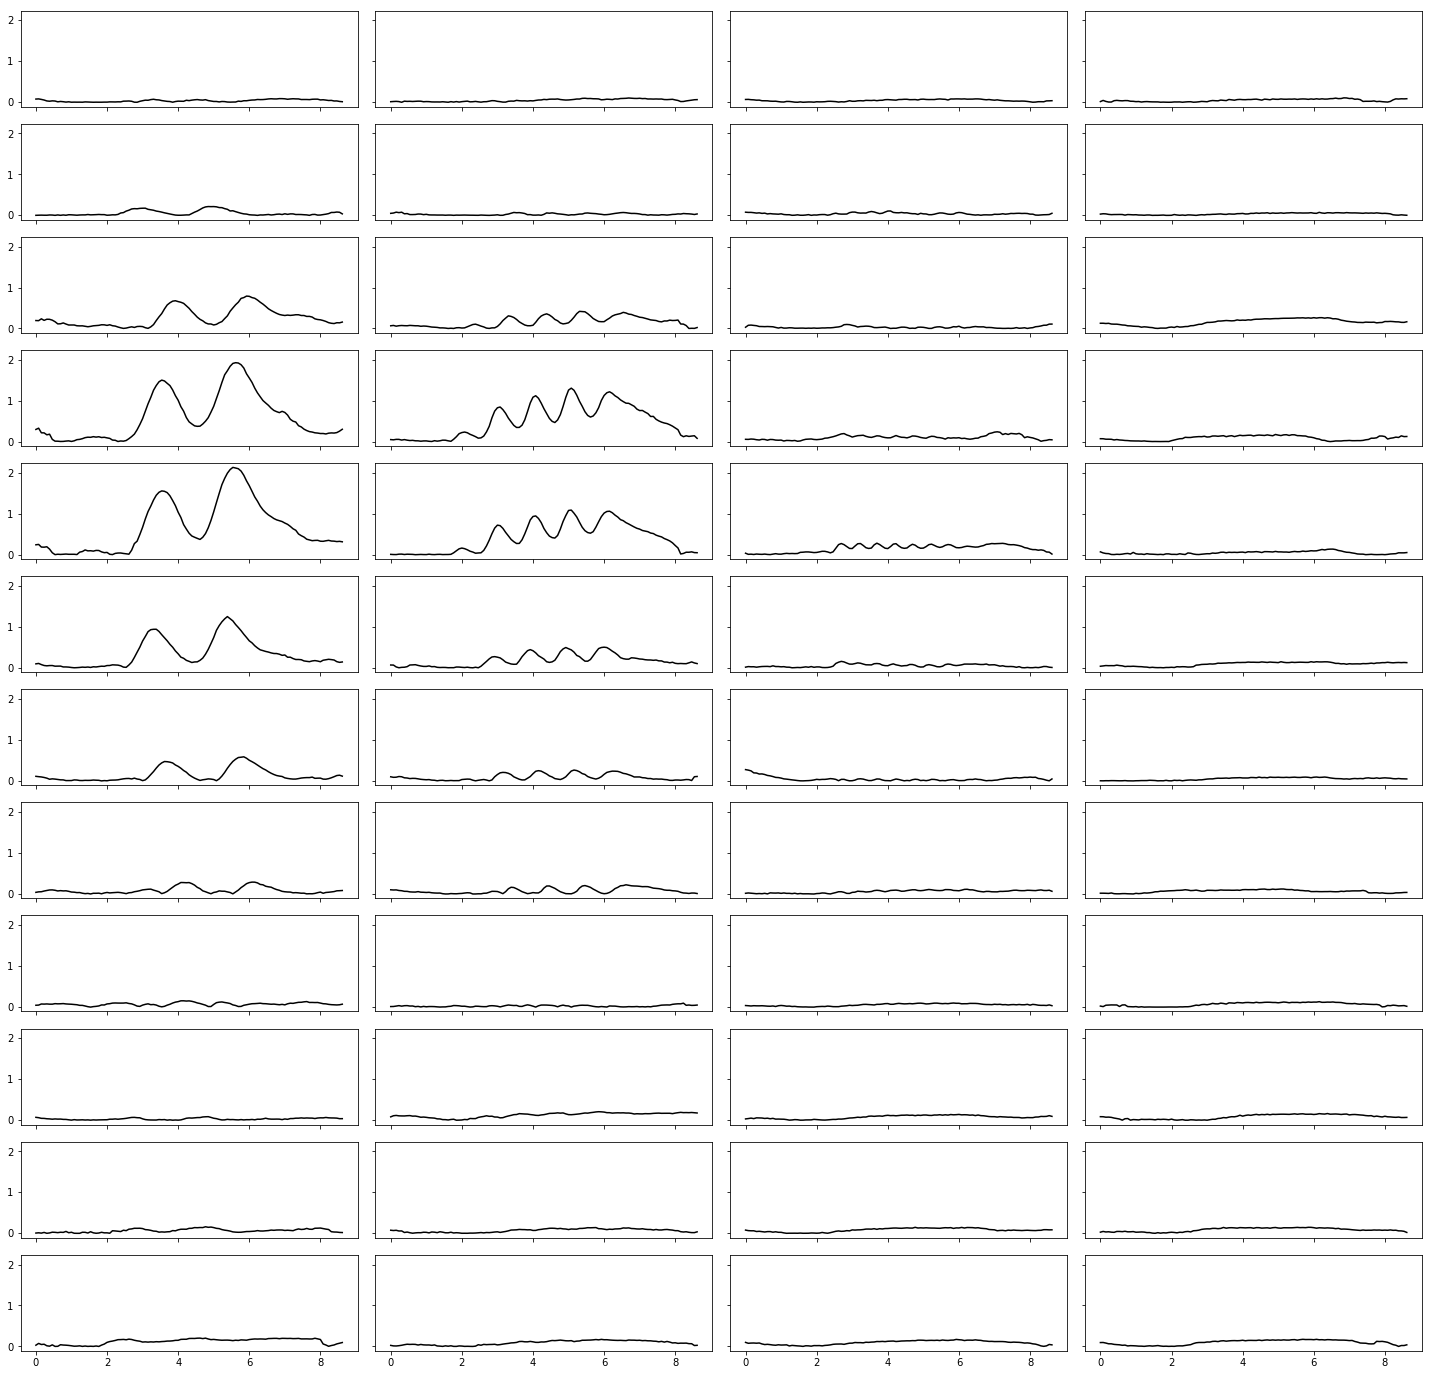

In [28]:
plot_data([np.abs(T4_Gcamp-T4_model)])

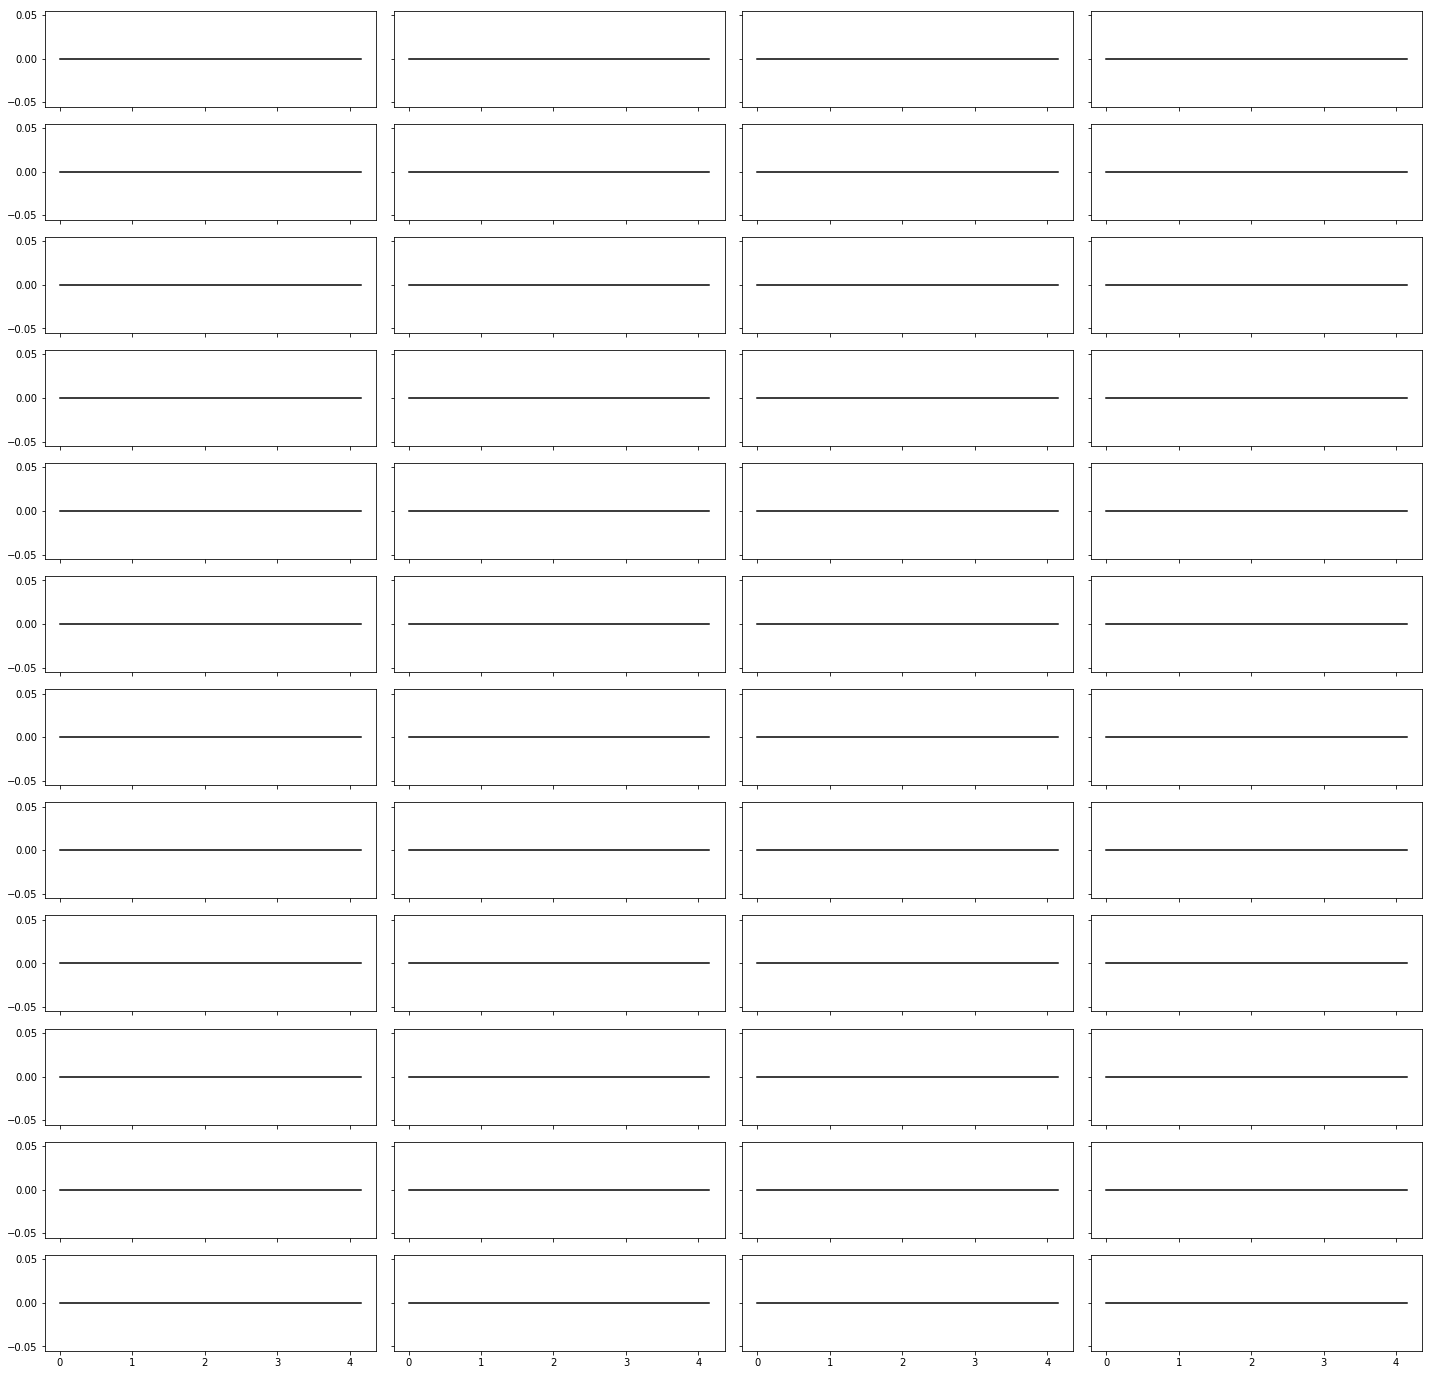

In [48]:
plot_data([T4_model])

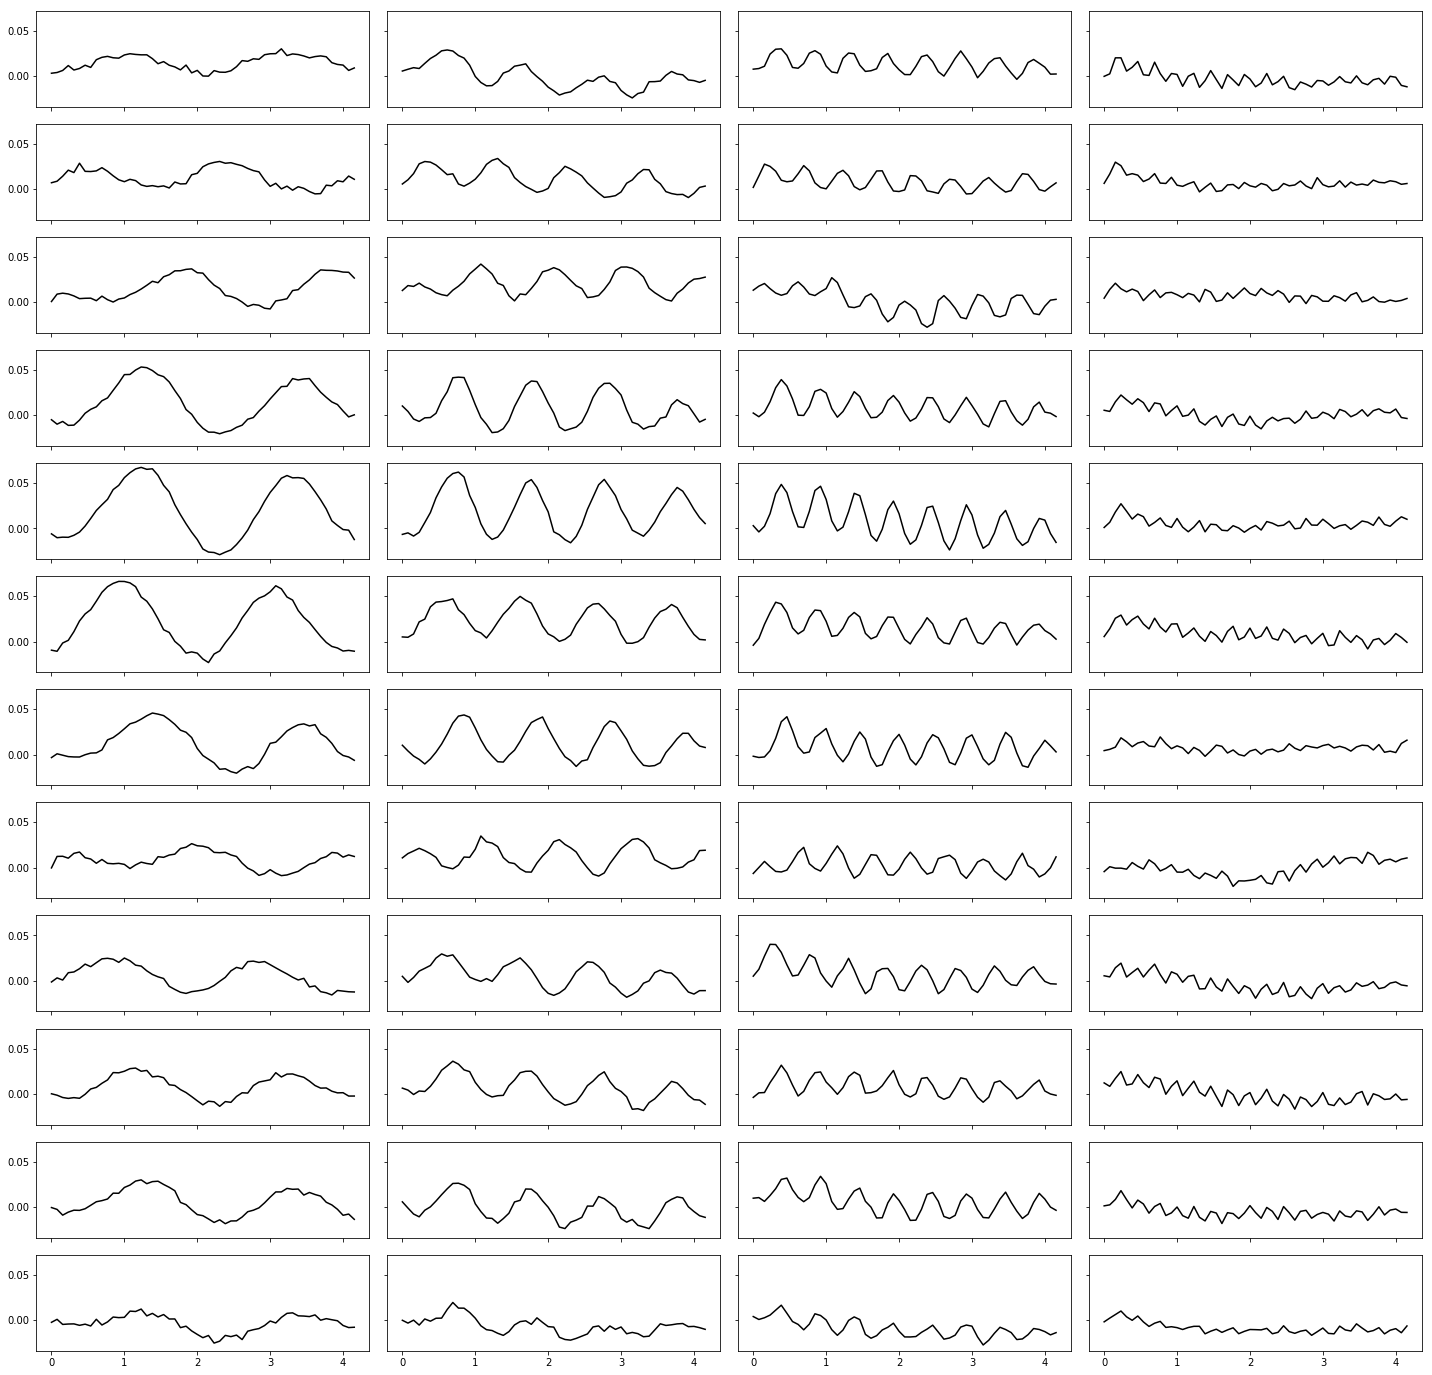

In [49]:
plot_data([T4_Arclight])

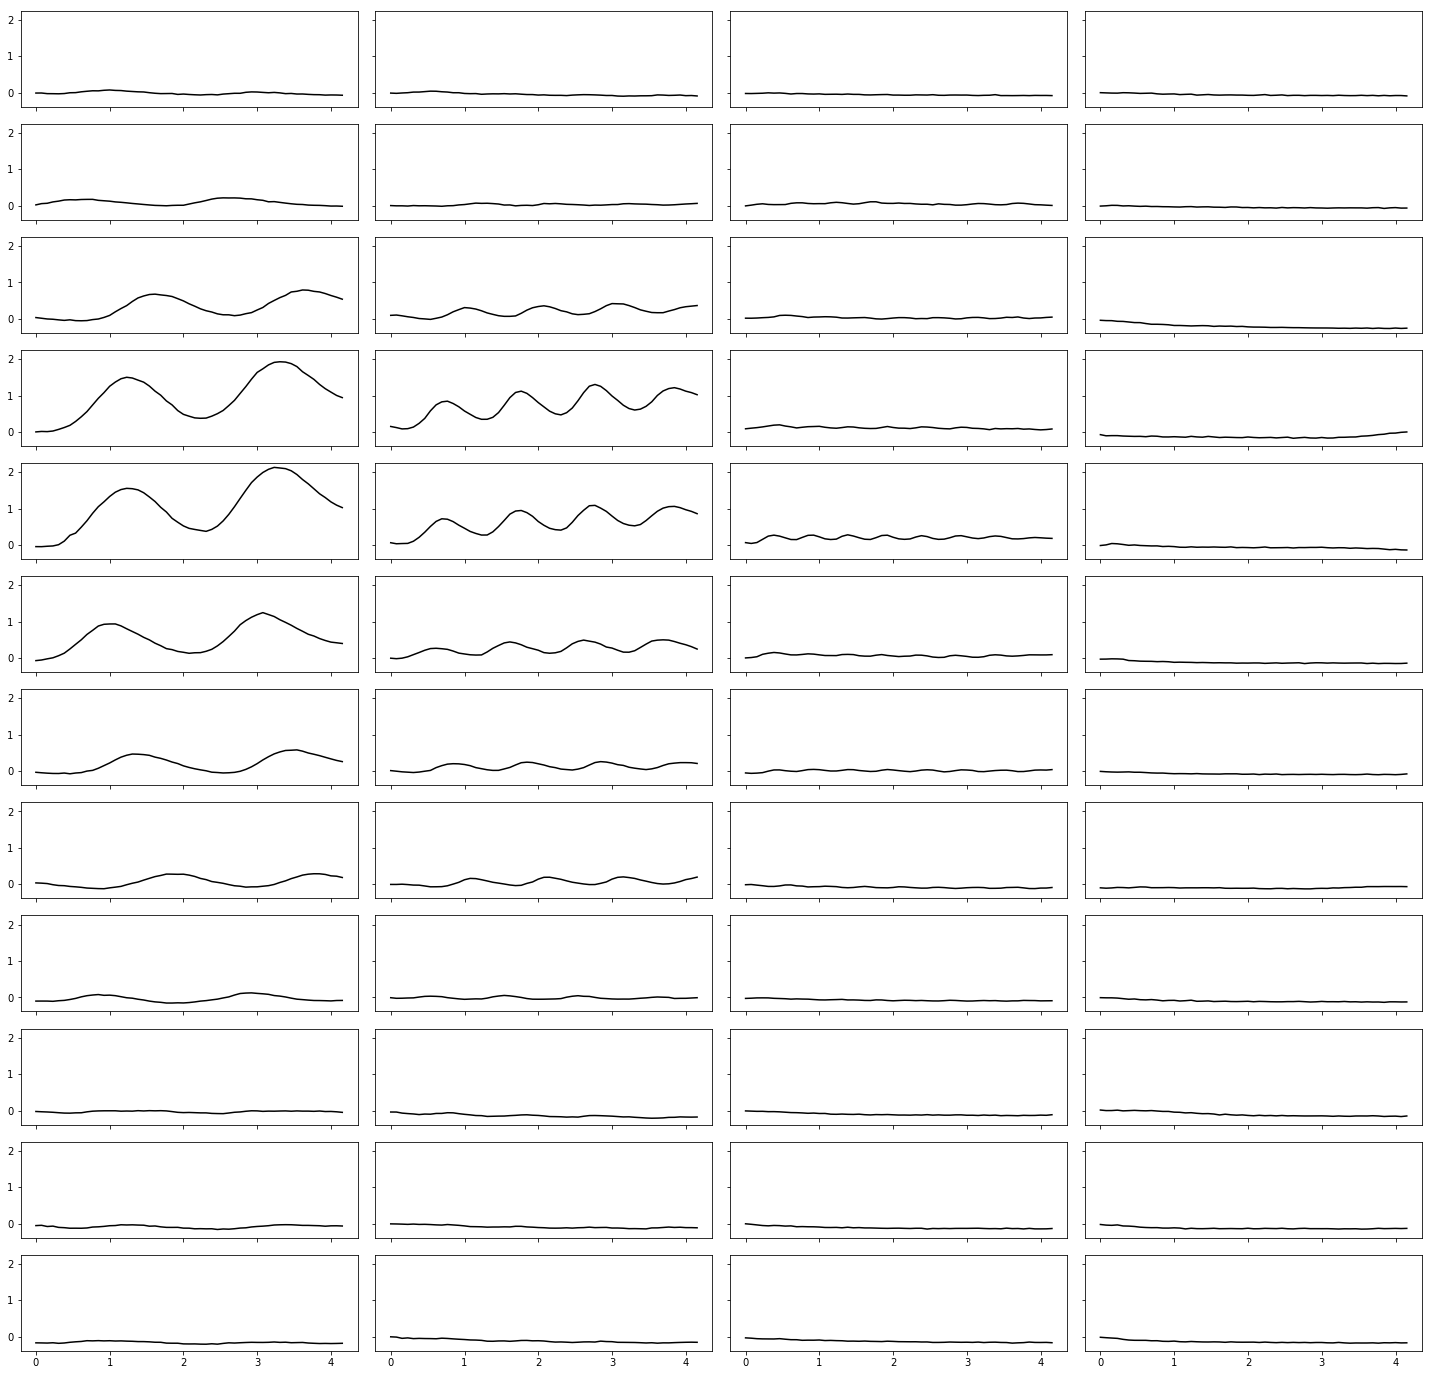

In [50]:
plot_data([T4_Gcamp])